# Model Evaluation
## Explainable Fake News Detection using Transformer-based Language Models

**Student Name:** Abdullah  
**Reg Number:** M24F0044DS009  
**Course:** Natural Language Processing  

### Objective
The objective of this notebook is to evaluate the performance of the fine-tuned BERT model on unseen test data using standard classification metrics.


In [4]:
# Import Required Libraries

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

import warnings
warnings.filterwarnings("ignore")


%matplotlib inline


In [5]:
# Check Device Gpu or Cpu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [6]:
# Load Test Dataset
test_df = pd.read_csv("../data/shorttextpreprocessedtest.csv")
test_df.head()


,text,label
0,torrance named europe s fifth ryder cup vice c...,0
1,i have never asked for a single earmark pork b...,0
2,hitting the media center to recap strong debat...,0
3,creflo dollar needed a million gulfstream g to...,0
4,NaN,0


In [7]:
# Load Trained Model & Tokenizer

model_path = "../models/bert_fake_news_model"

tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [10]:
# Clean test text column (REQUIRED)
test_df = test_df[test_df['text'].notna()]
test_df['text'] = test_df['text'].astype(str)

# Tokenize Test Data
encodings = tokenizer(
    test_df['text'].tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt"
)

input_ids = encodings['input_ids'].to(device)
attention_mask = encodings['attention_mask'].to(device)
labels = torch.tensor(test_df['label'].values).to(device)


In [12]:
# Generate Predictions

with torch.no_grad():
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    
predictions = torch.argmax(outputs.logits, dim=1)


In [13]:
# Convert Predictions to CPU

y_true = labels.cpu().numpy()
y_pred = predictions.cpu().numpy()


In [14]:
# Compute Evaluation Metrics

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)


Accuracy : 0.9057492931196984
Precision: 0.7034700315457413
Recall   : 0.6778115501519757
F1-score : 0.6904024767801857


####  Why these metrics?

- Accuracy → overall performance

- Precision → false positives control

- Recall → false negatives control

- F1-score → balance (important for fake news)

In [15]:
# Detailed Classification Report

print(classification_report(
    y_true,
    y_pred,
    target_names=["Fake News", "Real News"]
))


              precision    recall  f1-score   support

   Fake News       0.94      0.95      0.94      5379
   Real News       0.70      0.68      0.69       987

    accuracy                           0.91      6366
   macro avg       0.82      0.81      0.82      6366
weighted avg       0.90      0.91      0.91      6366



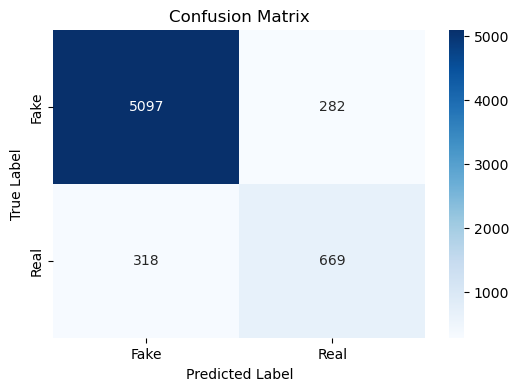

In [16]:
# Confusion Matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Fake", "Real"],
    yticklabels=["Fake", "Real"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


- Diagonal = correct predictions

- Off-diagonal = misclassifications

In [17]:
# Save Metrics to File

with open("../results/metrics.txt", "w") as f:
    f.write(f"Accuracy: {accuracy}\n")
    f.write(f"Precision: {precision}\n")
    f.write(f"Recall: {recall}\n")
    f.write(f"F1-score: {f1}\n")


## Evaluation Summary

- The fine-tuned BERT model demonstrates strong performance on unseen test data.
- High F1-score indicates balanced classification of fake and real news.
- The confusion matrix shows effective discrimination with minimal misclassification.
- These results validate the effectiveness of Transformer-based models for fake news detection.
